We want to analyze participants and patterns of participation across IETF groups. 

Specifically, what are the lengths of participation? Are there new cohorts of participation over time? What is attrition like in IETF mailing list participation?

## Setup and gather data

Start by importing the necessary libraries.

In [1]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import scipy.cluster.hierarchy as sch
import email

In [2]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [3]:
#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

Let's start with a single IETF mailing list. (Later, we can expand to all current groups, or all IETF lists ever.)

In [4]:
list_url = 'https://www.ietf.org/mail-archive/text/perpass/' # perpass happens to be one that I subscribe to

ietf_archives_dir = '../../ietf-archives' # relative location of the ietf-archives directory/repo

list_archive = mailman.open_list_archives(list_url, ietf_archives_dir)
activity = None
activity = Archive(list_archive).get_activity()

43
Opening 43 archive files


## When do people first send to the mailing list?

For this mailing list, we'll create a histogram of people in the list and when they sent their first message to the list.

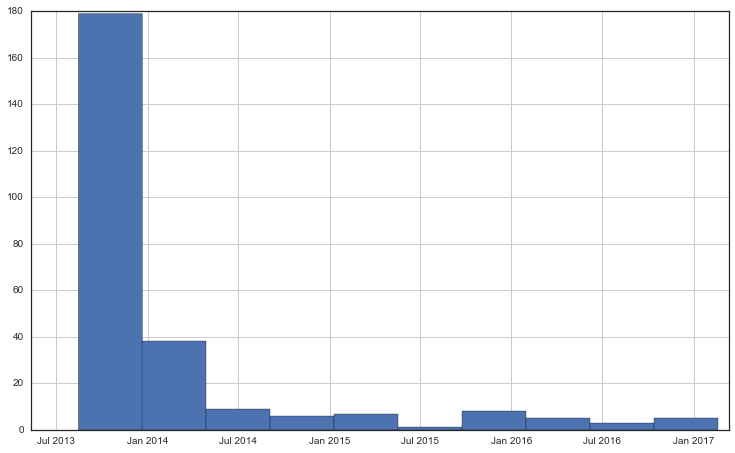

In [5]:
fig = plt.figure(figsize=(12.5, 7.5))

(activity > 0).idxmax().hist()

fig.axes[0].xaxis_date()

For this mailing list, it appears that most people joined the list near the beginning of the list, and few new people join over time.

## When do people first join any IETF list?

In [6]:
f = open('ietf_lists_normalized.txt', 'r')
ietf_lists = list(set(f.readlines())) # remove duplicates, which is a bug in list maintenance

In [7]:
activity.T[:1]

Date,735095,735096,735097,735098,735099,735100,735101,735102,735103,735104,...,736511,736512,736513,736514,736515,736516,736517,736518,736519,736520
From,,,,,,,,,,,,,,,,,,,,,
"""Adrian Farrel"" <adrian@olddog.co.uk>",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We want to combine these activity frames where the values are the number of messages sent on that date.

In [ ]:
for i_list in ietf_lists[:5:
    try:
        i_list_archive = mailman.open_list_archives(i_list, ietf_archives_dir)
        i_activity = Archive(i_list_archive).get_activity()
        activity = pd.merge(activity, i_activity, how='outer', left_index=True, right_index=True)
    except MissingDataException as e:
        logging.error(exc_info=True)

144
Opening 144 archive files
unknown-8bit unknown encoding in message <0FVU00DHMFEE3B@mta5.rcsntx.swbell.net>, using UTF-8 instead
Date parsing error on: 
Wed, 30 Jan 02 03:04:51 GMT Standard Time
"us-ascifrom enum-bounces@ietf.org tue nov 07 19:31:30 2006 unknown encoding in message <00f201c702cd$26a7a260$68418182@cis.neustar.com>, using UTF-8 instead
Date parsing error on: 
Fri, 32 Jan 2008 19:05:18 +0900
Date parsing error on: 
������, 01 ���� 2002 20:15:33 +0800
Date parsing error on: 
emonPortOptions=Port=smtp,Addr=127.0.0.1, Name=MTA
default_charset unknown encoding in message <200112050320.WAA23582@ietf.org>, using UTF-8 instead
default_charset unknown encoding in message <200112050322.WAA23640@ietf.org>, using UTF-8 instead
Date parsing error on: 
Sat, 02 Feb 02 01:01:05 GMT Standard Time
127
Opening 127 archive files
iso-4461-5 unknown encoding in message <E1DHIEC-0003gj-0d@mx2.foretec.com>, using UTF-8 instead
iso-4461-5 unknown encoding in message <E1DHIEC-0003gj-0d@mx2.for

02:08:09 ERROR:Error while removing duplicate messages, maybe timezone issues?
Traceback (most recent call last):
  File "/Users/nick/code/mailing-list-analysis/bigbang/bigbang/archive.py", line 67, in __init__
    self.data.drop_duplicates(inplace=True)
  File "/usr/local/lib/python2.7/site-packages/pandas/core/frame.py", line 3535, in drop_duplicates
    duplicated = self.duplicated(subset, keep=keep)
  File "/usr/local/lib/python2.7/site-packages/pandas/core/frame.py", line 3582, in duplicated
    labels, shape = map(list, zip(*map(f, vals)))
  File "/usr/local/lib/python2.7/site-packages/pandas/core/frame.py", line 3570, in f
    vals, size_hint=min(len(self), _SIZE_HINT_LIMIT))
  File "/usr/local/lib/python2.7/site-packages/pandas/core/algorithms.py", line 471, in factorize
    labels = table.get_labels(values, uniques, 0, na_sentinel, check_nulls)
  File "pandas/_libs/hashtable_class_helper.pxi", line 1367, in pandas._libs.hashtable.PyObjectHashTable.get_labels
ValueError: tzinfo

In [ ]:
activity

In [ ]:
fig = plt.figure(figsize=(12.5, 7.5))

(activity > 0).idxmax().hist()

fig.axes[0].xaxis_date()